In [1]:
# Importing the Keras libraries and packages

import tensorflow 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten
import numpy as np

In [2]:
# Initialising the resnet50
classifier = VGG16(input_shape= (224,224,3),include_top=False,weights='imagenet')
#classifier = DenseNet121(input_shape= (224,224,3),include_top=False,weights='imagenet')
#classifier = ResNet50( input_shape=(224,224,3), include_top= False) # include_top will consider the new weights
#classifier = VGG19( input_shape=(224,224,3), include_top= False) # include_top will consider the new weights
#classifier = InceptionV3( input_shape=(224,224,3), include_top= False) # include_top will consider the new weights


classifier.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
#don't train existing weights
for layer in classifier.layers:
    layer.trainable = False

In [4]:
classifier1 = classifier.output#head model
classifier1 = Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=64, activation='relu')(classifier1)#adding layer of dense
classifier1 = Dense(units=1, activation='sigmoid')(classifier1)#again adding another layer of dense

In [5]:
model = Model(inputs = classifier.input , outputs = classifier1)
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:

# Part 2 - Fitting the CNN to the images

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#use the image data generator to import the images from the dataset
#data augmentation
train_datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        rescale = 1./255)

test_datagen = ImageDataGenerator(rescale=1. / 255)


#makes sure you provide the same target as initialised for the image size
training_set = train_datagen.flow_from_directory(r'C:\Users\RAHUL\Downloads\archive\chest_xray\chest_xray\train',target_size=(224, 224),batch_size=32,class_mode='binary')

test_set = test_datagen.flow_from_directory(r'C:\Users\RAHUL\Downloads\archive\chest_xray\chest_xray\test',target_size=(224, 224),batch_size=32,class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor= "val_accuracy" , min_delta= 0.01, patience= 3, verbose=1)
mc = ModelCheckpoint(filepath="my_model_vgg16.h5", monitor="val_accuracy", verbose=1, save_best_only= True)

In [8]:
#fit the model
#it will take some time to train
history = model.fit(training_set,validation_data=test_set,epochs=3,steps_per_epoch=len(training_set),validation_steps=len(test_set),callbacks=[es,mc])

Epoch 1/3
163/163 [==============================] - ETA: 0s - loss: 0.3045 - accuracy: 0.8786
Epoch 1: val_accuracy improved from -inf to 0.83333, saving model to my_model_vgg16.h5
163/163 [==============================] - 864s 5s/step - loss: 0.3045 - accuracy: 0.8786 - val_loss: 0.4070 - val_accuracy: 0.8333
Epoch 2/3
163/163 [==============================] - ETA: 0s - loss: 0.1234 - accuracy: 0.9551
Epoch 2: val_accuracy improved from 0.83333 to 0.88782, saving model to my_model_vgg16.h5
163/163 [==============================] - 827s 5s/step - loss: 0.1234 - accuracy: 0.9551 - val_loss: 0.3094 - val_accuracy: 0.8878
Epoch 3/3
163/163 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9611
Epoch 3: val_accuracy did not improve from 0.88782
163/163 [==============================] - 826s 5s/step - loss: 0.1054 - accuracy: 0.9611 - val_loss: 0.4388 - val_accuracy: 0.8574


In [9]:
#save model
model.save(r'C:/projects/corona x-ray images predication/my_model_vgg16.h5')

In [10]:
#loading model
loaded_model = tensorflow.keras.models.load_model(r'C:/projects/corona x-ray images predication/my_model_vgg16.h5')
loaded_model.evaluate(test_set)

20/20 [==============================] - 88s 4s/step - loss: 0.4388 - accuracy: 0.8574


[0.43875595927238464, 0.8573718070983887]

In [11]:
#prediction of test set
y_pred = model.predict(test_set)
import numpy as np
y_pred = np.argmax(y_pred , axis=1)

20/20 [==============================] - 87s 4s/step


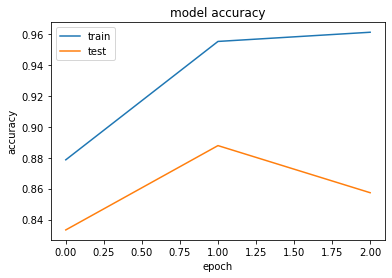

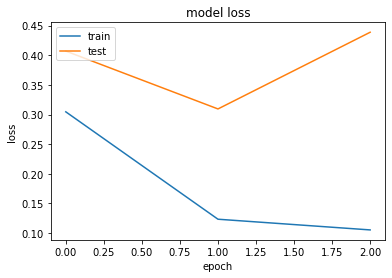

In [12]:
#plotting acc and loss
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 121ms/step
Covid


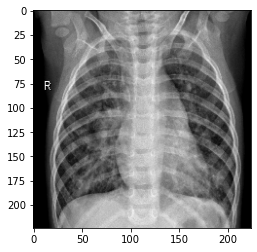

In [17]:
# for only one prediction
import numpy as np
from keras.preprocessing import image

test_image = tensorflow.keras.preprocessing.image.load_img(r'C:\Users\RAHUL\Downloads\archive\chest_xray\test\PNEUMONIA\person15_virus_46.jpeg',target_size=(224,224))
plt.imshow(test_image)
test_image =tensorflow.keras.preprocessing.image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = loaded_model.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
    prediction = 'Normal'
else:
    prediction = 'Covid'
print(prediction)

In [14]:
# plot confusion metrix
y_pred = []
y_test = []
import os

for i in os.listdir(r'C:\Users\RAHUL\Downloads\archive\chest_xray\chest_xray\test\NORMAL'):
    img = tensorflow.keras.preprocessing.image.load_img(r'C:\Users\RAHUL\Downloads\archive\chest_xray\chest_xray\test\NORMAL/' + i, target_size=(224,224))
    img = tensorflow.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    p = model.predict(img)
    y_test.append(p[0, 0])
    y_pred.append(1)

for i in os.listdir(r'C:\Users\RAHUL\Downloads\archive\chest_xray\chest_xray\test\PNEUMONIA'):
    img = tensorflow.keras.preprocessing.image.load_img(r"C:\Users\RAHUL\Downloads\archive\chest_xray\chest_xray\test\PNEUMONIA/"+ i, target_size=(224,224))
    img = tensorflow.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    p = model.predict(img)
    y_test.append(p[0, 0])
    y_pred.append(0)

y_pred = np.array(y_pred)
y_test = np.array(y_test).astype(int)

1/1 [==============================] - 0s 141ms/step


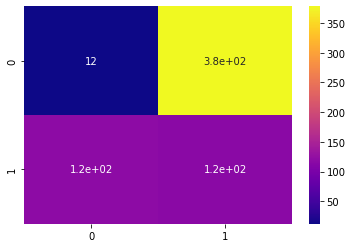

              precision    recall  f1-score   support

           0       0.09      0.03      0.05       390
           1       0.23      0.50      0.32       234

    accuracy                           0.21       624
   macro avg       0.16      0.26      0.18       624
weighted avg       0.15      0.21      0.15       624



In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, cmap="plasma", annot=True)
plt.show()

print(classification_report(y_pred, y_test))